In [1]:
from parcels import FieldSet, ParticleSet, JITParticle, ParticleFile, plotTrajectoriesFile
from parcels import AdvectionRK4
import numpy as np
from datetime import timedelta as delta
%matplotlib inline

Data needs to be downloaded to work in this notebook

I'm trying to use the NEMO mask as I can't find one for eReefs. I can't find enough details on this to determine if this is a good method or not


In [13]:
data_path = 'NemoCurvilinear_data/'
filenames = {'U': {'lon': data_path + 'mesh_mask.nc4',
                   'lat': data_path + 'mesh_mask.nc4',
                   'data': data_path + 'gbr1_simple_2023-02-01.nc'},
             'V': {'lon': data_path + 'mesh_mask.nc4',
                   'lat': data_path + 'mesh_mask.nc4',
                   'data': data_path + 'gbr1_simple_2023-02-01.nc'}}
# Only change has the data file from the NEMO tutorials to the eReefs one. 
# Maybe 
variables = {'U': 'u',
             'V': 'v'}
dimensions = {'lon': 'glamf', 'lat': 'gphif', 'time': 'time'}
field_set = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 2, the array at index 0 has size 2389 and the array at index 1 has size 1021

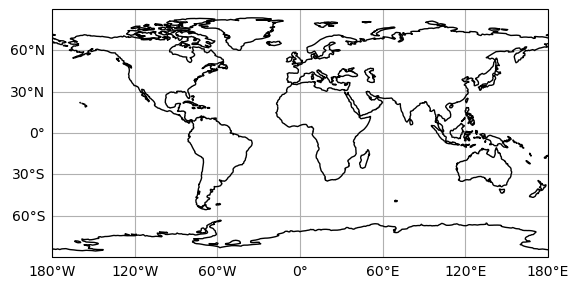

In [11]:
field_set.U.show()

From the NEMO Tutorial

In [5]:
# Start 20 particles on a meridional line at 180W
npart = 20
lonp = -180 * np.ones(npart)
latp = [i for i in np.linspace(-70, 88, npart)]

# Create a periodic boundary condition kernel
def periodicBC(particle, fieldset, time):
    if particle.lon > 180:
        particle.lon -= 360

pset = ParticleSet.from_list(field_set, JITParticle, lon=lonp, lat=latp)
pfile = ParticleFile("nemo_particles", pset, outputdt=delta(days=1))
kernels = pset.Kernel(AdvectionRK4) + periodicBC
pset.execute(kernels, runtime=delta(days=50), dt=delta(hours=6),
             output_file=pfile)

INFO: Compiled ArrayJITParticleAdvectionRK4periodicBC ==> C:\Users\Matthew\AppData\Local\Temp\parcels-tmp\lib5733f6054b5a2f69c87d111a12797c11_0.dll


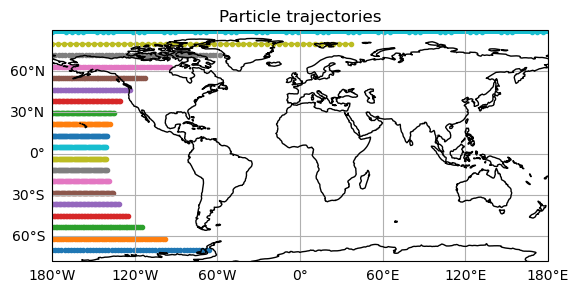

<module 'matplotlib.pyplot' from 'C:\\Users\\Matthew\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
plotTrajectoriesFile("nemo_particles.zarr")

In [7]:
pset = ParticleSet.from_list(field_set, JITParticle, lon=lonp, lat=latp)
pset.populate_indices()

## Drifters in eReefs


In [ ]:
npart = 10  # number of particles to be released
time = np.arange(0,npart)*timedelta(minutes=40).total_seconds()  # release every particle in a delayed mode

pset = ParticleSet.from_line(fieldset=fieldset, 
                             pclass=JITParticle,
                             size=npart,             # releasing X particles
                             start=(147.5, -19.5),   # releasing on a line: the start longitude and latitude
                             finish=(148.0, -19.0),
                             time=time)  # release every particle X hour

In [ ]:
print(pset)
pset.show(field=fieldset.U)

In [ ]:
output_file = pset.ParticleFile(name="CurrentParticles.zarr", outputdt=timedelta(hours=1))  # the file name and the time step of the outputs

pset.execute(AdvectionRK4,  # the kernel (which defines how particles move)
             runtime=timedelta(days=10), # the total length of the run
             dt=timedelta(minutes=5), # the timestep of the kernel
             output_file=output_file,
             recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

output_zarr = 'CurrentParticles.zarr'
try:
    os.remove(output_zarr)
except OSError:
    pass

In [ ]:
parcels = xr.open_dataset(output_zarr)
#parcels

In [ ]:
print(pset)
pset.show(field=fieldset.U)

In [ ]:
plotTrajectoriesFile(output_zarr, mode='movie2d_notebook')

In [ ]:
plotTrajectoriesFile(output_zarr, mode='hist2d', bins=[30, 20]);